In [60]:
import geopandas
from ipyleaflet import Map, Marker, Popup, basemaps, GeoData, MarkerCluster, FullScreenControl, LayersControl, basemap_to_tiles

import copy

%matplotlib inline
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np

# NWIS API library
import dataretrieval.nwis as nwis

In [2]:
# Filesystem
import sys
sys.path.append("../../")

Parameters:

Temperature, air, °C : 00010

Nitrate plus nitrite, water, in situ, milligrams per liter as nitrogen: 99133

Dissolved oxygen, water, unfiltered, milligrams per liter: 00300

Discharge, cubic feed per second : 00060

In Washington State:

Multiple sites have temperature, DO data, and discharge
One site has nitrite/nitrate data (12473503)
No phosphate/phosphorus data

In [3]:
final_parameters = ["00060","00010","99133","00300"]
startDate = "2019-04-20" # retroactively edited to reflect the nature of the data
endDate = "2021-07-19"

In [4]:
# ringold_iv = nwis.get_record(sites="12473503",service="iv",parameterCd=final_parameters,start=startDate,end=endDate)
# ringold_dv = nwis.get_record(sites="12473503",service="dv",parameterCd=final_parameters,start=startDate,end=endDate)

%store -r ringold_iv
%store -r ringold_dv

In [27]:
# Copy raw RINGOLD IV dataset from NWIS
ringold_iv_final = copy.deepcopy(ringold_iv)

# Isolate the target parameters
ringold_iv_final = ringold_iv_final[final_parameters]

# Set all impossible values to NaN
for column in ringold_iv_final:
    ringold_iv_final[ringold_iv_final[column] < 0] = np.nan

# Delete all NaN
ringold_iv_final.dropna(inplace=True)

# Print
ringold_iv_final

,00060,00010,99133,00300
datetime,,,,
2019-04-29T10:15:00.000-07:00,74.4,10.1,2.6,11.7
2019-04-29T10:30:00.000-07:00,75.5,10.3,2.6,11.7
2019-04-29T10:45:00.000-07:00,76.6,10.5,2.6,11.6
2019-04-29T11:00:00.000-07:00,77.7,10.7,2.6,11.6
2019-04-29T11:15:00.000-07:00,76.6,10.9,2.6,11.5
...,...,...,...,...
2021-05-02T10:45:00.000-07:00,36.1,13.6,2.8,10.5
2021-05-02T11:00:00.000-07:00,36.1,13.9,2.8,10.5
2021-05-02T11:15:00.000-07:00,36.8,14.1,2.8,10.4


In [32]:
dv_parameters = [
    '00300_Mean',
    '99133_Mean',
    '00010_Mean',
    '00060_Mean'
]

# Copy raw RINGOLD DV dataset from NWIS
ringold_dv_final = copy.deepcopy(ringold_dv)

# Isolate the target parameters
ringold_dv_final = ringold_dv_final[dv_parameters]

# Set all impossible values to NaN
for column in ringold_dv_final:
    ringold_dv_final[ringold_dv_final[column] < 0] = np.nan

# Delete all NaN
ringold_dv_final.dropna(inplace=True)

# Print
ringold_dv_final

,00300_Mean,99133_Mean,00010_Mean,00060_Mean
datetime,,,,
2019-04-30 00:00:00+00:00,10.9,3.2,12.9,51.0
2019-05-01 00:00:00+00:00,10.6,3.4,13.7,40.7
2019-05-02 00:00:00+00:00,10.6,3.3,13.9,42.6
2019-05-03 00:00:00+00:00,10.5,2.9,14.6,58.5
2019-05-04 00:00:00+00:00,10.1,3.0,16.0,50.5
...,...,...,...,...
2021-04-27 00:00:00+00:00,10.2,2.8,14.5,36.1
2021-04-28 00:00:00+00:00,10.1,3.1,15.3,52.7
2021-04-29 00:00:00+00:00,9.7,2.4,16.9,69.6


,STATION,NAME,PRCP
DATE,,,
2018-06-26,USC00453883,"ICE HARBOR DAM, WA US",0.00
2018-06-27,USC00453883,"ICE HARBOR DAM, WA US",0.00
2018-06-28,USC00453883,"ICE HARBOR DAM, WA US",0.00
2018-07-01,USC00453883,"ICE HARBOR DAM, WA US",0.00
2018-07-02,USC00453883,"ICE HARBOR DAM, WA US",0.00
...,...,...,...
2021-07-21,USC00453883,"ICE HARBOR DAM, WA US",0.03
2021-07-22,USC00453883,"ICE HARBOR DAM, WA US",0.00
2021-07-23,USC00453883,"ICE HARBOR DAM, WA US",0.00


Text(0, 0.5, 'Precipitation, in.')

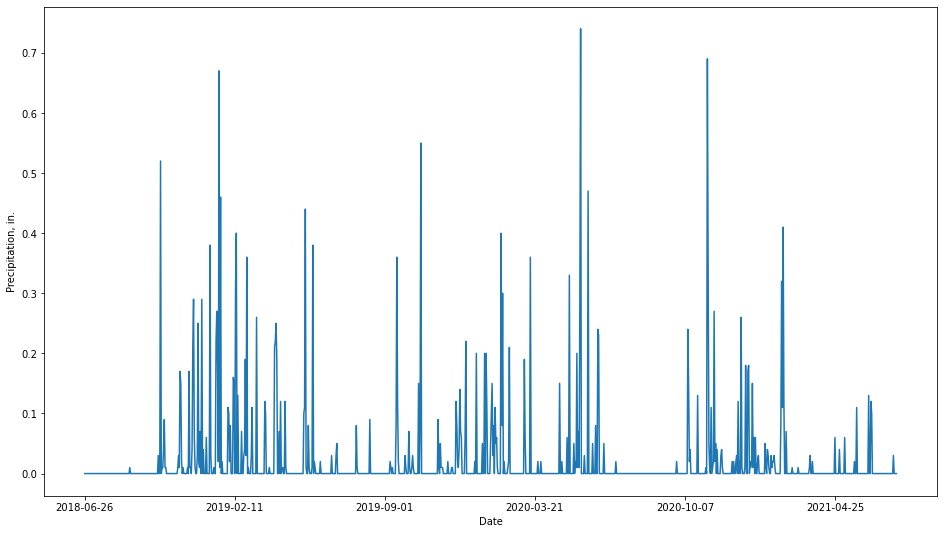

In [83]:
NOAA_DATA = pd.read_csv("noaa_station_data.csv")
NOAA_DATA = NOAA_DATA.set_index('DATE')
display(NOAA_DATA)

precip_plot = NOAA_DATA[["PRCP"]].plot(figsize=(16,9),legend=False)
precip_plot.set_xlabel("Date")
precip_plot.set_ylabel("Precipitation, in.")

TypeError: '<' not supported between instances of 'str' and 'Timestamp'

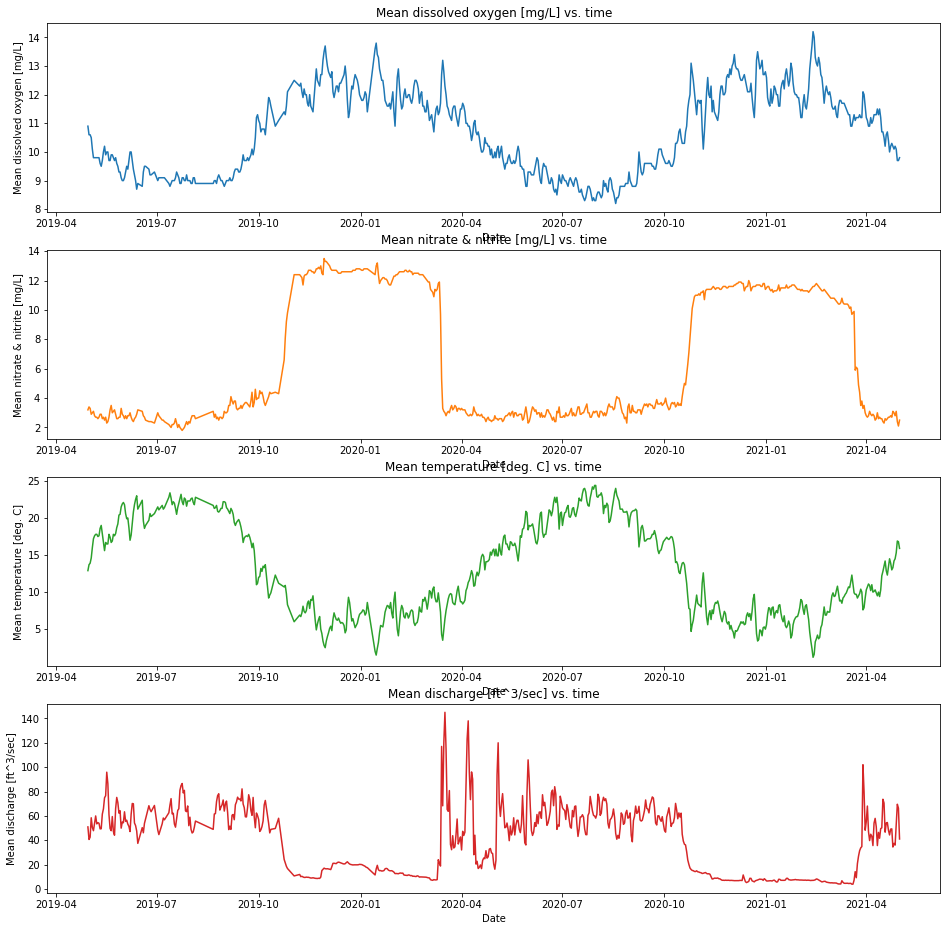

In [89]:
namesdv = {
    '00300_Mean':'Mean dissolved oxygen [mg/L]',
    '99133_Mean':'Mean nitrate & nitrite [mg/L]',
    '00010_Mean':'Mean temperature [deg. C]',
    '00060_Mean' : 'Mean discharge [ft^3/sec]'
}

namesdvarray = [
    'Mean dissolved oxygen [mg/L]',
    'Mean nitrate & nitrite [mg/L]',
    'Mean temperature [deg. C]',
    'Mean discharge [ft^3/sec]'
]

ringold_dv_toPlot = ringold_dv_final.rename(columns=namesdv)

plotdv = ringold_dv_toPlot.plot(subplots = True, figsize=(16,16), legend=False, xlabel='Date', sharex=False,sharey=False)

for subplotIndex in range(len(plotdv)):
    plotdv[subplotIndex].set_ylabel(namesdvarray[subplotIndex])
    plotdv[subplotIndex].set_title(namesdvarray[subplotIndex] + " vs. time")
    
frames = [ringold_dv_toPlot, NOAA_DATA]
precipframes = pd.concat(frames)
precipframes.sort_index(ascending=True)

precipframes.plot(figsize=(16,4))

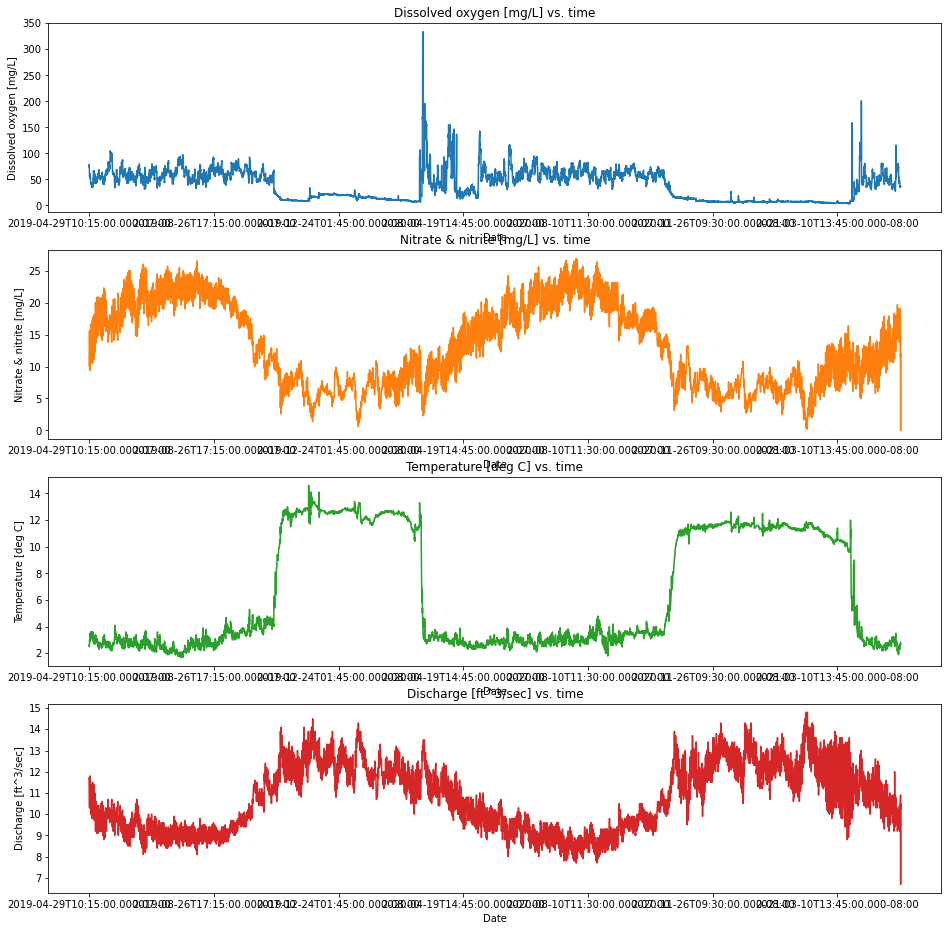

In [40]:
namesiv = {
    '00300':'Dissolved oxygen [mg/L]',
    '99133':'Nitrate & nitrite [mg/L]',
    '00010':'Temperature [deg C]',
    '00060':'Discharge [ft^3/sec]',
}

namesivarray = ['Dissolved oxygen [mg/L]',
'Nitrate & nitrite [mg/L]',
'Temperature [deg C]',
'Discharge [ft^3/sec]']

ringold_iv_toPlot = ringold_iv_final.rename(columns = namesiv)

plotiv = ringold_iv_toPlot.plot(subplots = True, legend=False,figsize=(16,16), xlabel='Date', sharex=False,sharey=False)

for subplotIndex in range(len(plotiv)):
    plotiv[subplotIndex].set_ylabel(namesivarray[subplotIndex])
    plotiv[subplotIndex].set_title(namesivarray[subplotIndex] + " vs. time")

In [41]:
kiona_start_date = '2018-06-26'
# kiona_iv = nwis.get_record(sites="12510500",service="iv",parameterCd=final_parameters,start=kiona_start_date,end=endDate)
# kiona_dv = nwis.get_record(sites="12510500",service="dv",parameterCd=final_parameters,start=kiona_start_date,end=endDate)
%store -r kiona_iv
%store -r kiona_dv

In [46]:
kiona_iv_final = kiona_iv.dropna(thresh=9)
kiona_iv_final = kiona_iv_final[["00060","00010","00300","99133"]]
kiona_iv_final

,00060,00010,00300,99133
datetime,,,,
2018-06-26T16:30:00.000-07:00,923.0,26.2,12.4,0.99
2018-06-26T16:45:00.000-07:00,923.0,26.2,12.4,1.00
2018-06-26T17:00:00.000-07:00,922.0,26.2,12.3,0.99
2018-06-26T17:15:00.000-07:00,912.0,26.2,12.2,0.99
2018-06-26T17:30:00.000-07:00,912.0,26.1,12.2,0.99
...,...,...,...,...
2021-07-19T22:45:00.000-07:00,1410.0,26.4,8.1,-999999.00
2021-07-19T23:00:00.000-07:00,1410.0,26.3,7.9,-999999.00
2021-07-19T23:15:00.000-07:00,1410.0,26.3,7.8,-999999.00


,Discharge [ft^3/sec],Temperature [deg C],Dissolved oxygen [mg/L],Nitrate & nitrite [mg/L]
datetime,,,,
2018-06-26T16:30:00.000-07:00,923.0,26.2,12.4,0.99
2018-06-26T16:45:00.000-07:00,923.0,26.2,12.4,1.00
2018-06-26T17:00:00.000-07:00,922.0,26.2,12.3,0.99
2018-06-26T17:15:00.000-07:00,912.0,26.2,12.2,0.99
2018-06-26T17:30:00.000-07:00,912.0,26.1,12.2,0.99
...,...,...,...,...
2020-09-30T23:45:00.000-07:00,2130.0,16.9,9.2,1.20
2020-10-01T00:00:00.000-07:00,2130.0,16.8,9.2,1.20
2020-10-01T00:15:00.000-07:00,2130.0,16.8,9.1,1.19


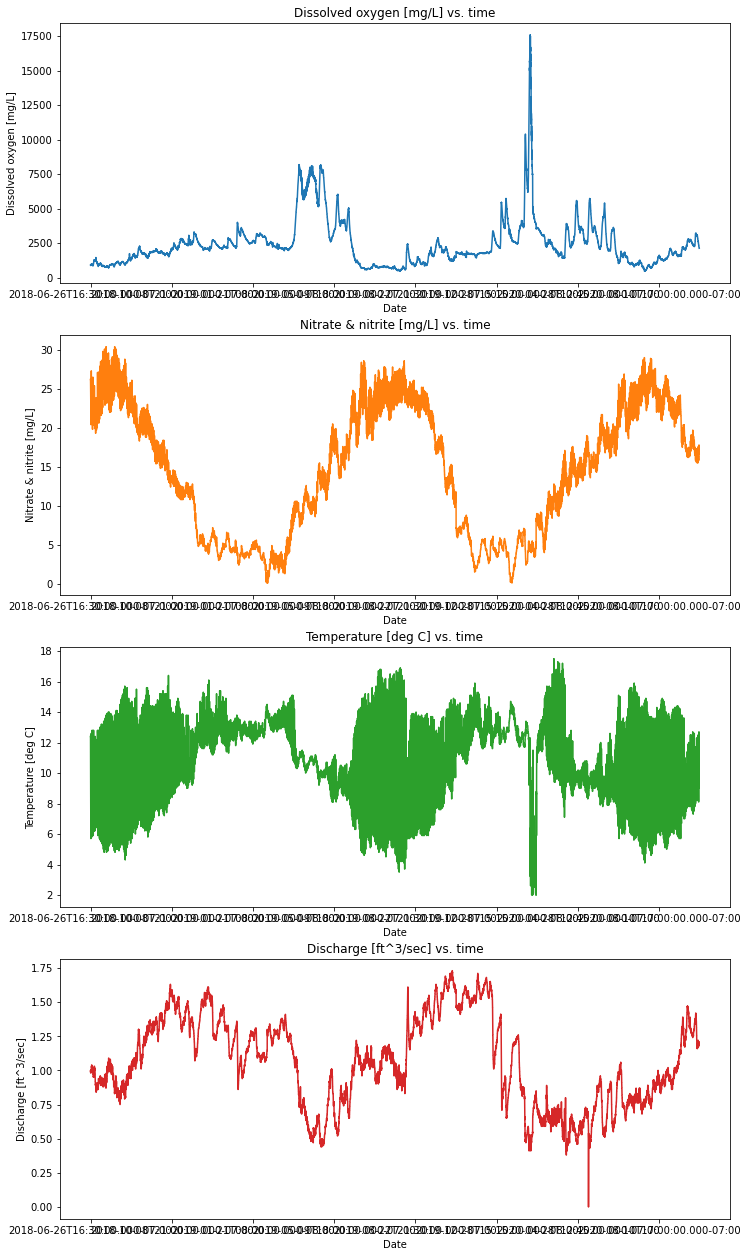

In [47]:
namesiv = {
    '00300':'Dissolved oxygen [mg/L]',
    '99133':'Nitrate & nitrite [mg/L]',
    '00010':'Temperature [deg C]',
    '00060':'Discharge [ft^3/sec]',
}

kiona_iv_toPlot = copy.deepcopy(kiona_iv_final)

kiona_iv_toPlot[kiona_iv_toPlot['99133'] < 0] = np.nan

kiona_iv_toPlot[kiona_iv_toPlot['00010'] < 0] = np.nan

kiona_iv_toPlot.dropna(thresh=1, inplace = True)

kiona_iv_toPlot.rename(columns=namesiv, inplace = True)

display(kiona_iv_toPlot)

# Graphing

kionaplot = kiona_iv_toPlot.plot(subplots=True, figsize=(12,22), legend = False, xlabel='Date', sharex=False,sharey=False)

for subplotIndex in range(len(kionaplot)):
    kionaplot[subplotIndex].set_ylabel(names_iv_array[subplotIndex])
    kionaplot[subplotIndex].set_title(names_iv_array[subplotIndex] + " vs. time")

<AxesSubplot:xlabel='Discharge [ft^3/sec]', ylabel='Nitrate & nitrite [mg/L]'>

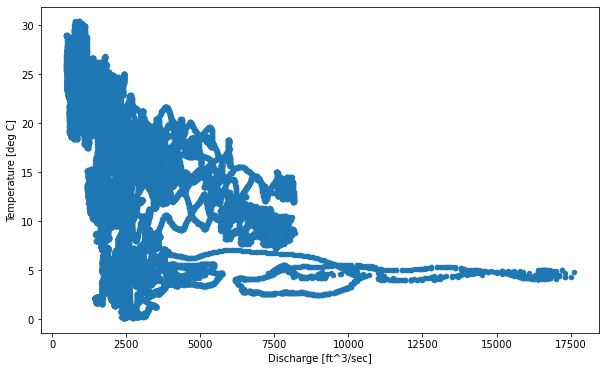

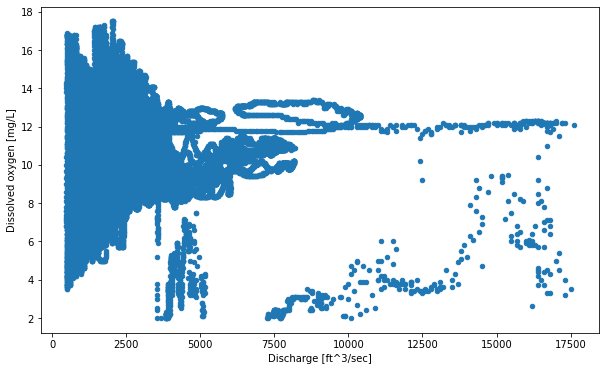

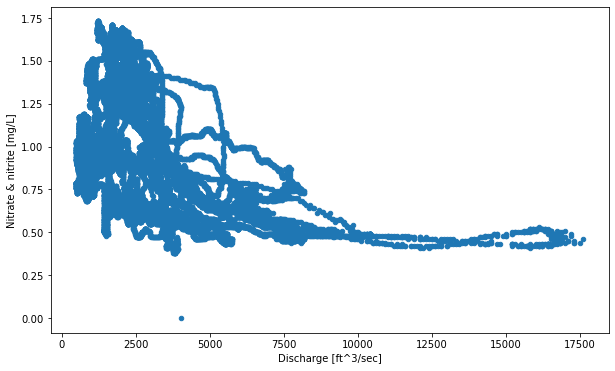

In [67]:
# Discharge [ft^3/sec]	Temperature [deg C]	Dissolved oxygen [mg/L]	Nitrate & nitrite [mg/L]
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Temperature [deg C]",kind='scatter',figsize=(10,6))
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Dissolved oxygen [mg/L]",kind='scatter',figsize=(10,6))
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Nitrate & nitrite [mg/L]",kind='scatter',figsize=(10,6))

In [21]:
nwis.get_info(sites=['12473503','12510500'])[0]

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,12473503,"SCBID WB 5 WASTEWAY NEAR MOUTH NEAR RINGOLD,WA",ST-DCH,463211.48,1191648.25,46.536522,-119.280069,N,S,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,12510500,"YAKIMA RIVER AT KIONA, WA",ST,461513.00,1192837.00,46.253467,-119.478079,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
m = Map(center=(47,-120), zoom=7)

m.add_layer(Marker(title='SCBID WB 5 WASTEWAY NEAR MOUTH NEAR RINGOLD,WA',location=(46.536522,-119.280069),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='YAKIMA RIVER AT KIONA, WA',location = (46.253467,-119.478079),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='NOAA STATION - ICE HARBOR DAM',location = (46.2447,-118.8786),rise_on_hover = True, draggable = False))

basemap1 = basemap_to_tiles(basemaps.Esri.WorldImagery)
m.add_layer(basemap1)

display(m)

Map(center=[47, -120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…